**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.** 



In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
import scipy.stats
import os

In [ ]:
#@title -- Downloading Data -- { display-mode: "form" }
# also create a directory for storing any outputs
import os
os.makedirs("output", exist_ok=True)

In [ ]:
#@title -- Auxiliary Functions -- { display-mode: "form" }

def plot_normal_distro(
    mu, sigma, space=200, normalize_to=None,
    ax=None, x=None, plot_func=None, **kwargs
):
    if ax is None:
        ax = plt.gca()
        
    nn = scipy.stats.norm(mu, sigma)
    
    if x is None:
        x = np.linspace(mu-2, mu+2, space)
    y = nn.pdf(x)
    
    if not normalize_to is None:
        y = y / np.max(y) * normalize_to
    
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    
    if plot_func is None:
        ax.plot(x, y, **kwargs)
        ax.set_xlim(np.min(x), np.max(x))
    elif plot_func == 'rotate':
        ax.plot(y, x, **kwargs)
        ax.set_ylabel("x")
        ax.set_xlabel("f(x)")
        ax.set_ylim(np.min(x), np.max(x))
    else:
        plot_func(x, y, ax=ax, **kwargs)
        ymin = y.min()
        ymin = min(0.8*ymin, 1.05*ymin)
        ymax = y.max()
        ymax = max(0.8*ymax, 1.05*ymax)
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(np.min(x), np.max(x))

    ax.grid(ls="--")
    ax.set_axisbelow(True)

def normal_prob(x, mu, sigma):
    x = np.asarray(x)
    n = x.shape[-1]
    xmu = x - mu
    return 1 / (np.power(2*np.pi, n/2) * np.power(np.linalg.det(sigma), 0.5)   ) * np.exp(
        -1/2 * xmu.transpose() @ np.linalg.inv(sigma) @ xmu
    )

def plot_normal_distro_2d(mu, sigma, x_pre=2, x_post=2, x_res=50, ax=None):
    if ax is None:
        ax = plt.gca()
        
    xx = np.linspace(mu-x_pre, mu+x_post, x_res)
    x, y = np.meshgrid(xx, xx, sparse=False)
    
    z = np.zeros_like(x)

    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            z[i,j] = normal_prob([x[i,j], y[i,j]], mu, sigma)
            
    mappable = ax.contour(x, y, z)
    ax.set_aspect('equal')
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    plt.colorbar(label="$f(\mathbf{x}; \mathbf{\mu}, \Sigma)$", mappable=mappable)
    
    ax.grid(ls="--")
    ax.set_axisbelow(True)
    
def plot_distro(x, gp, intervals=True, ax=None, xlabel="x", ylabel="y"):
    if ax is None:
        ax = plt.gca()

    y_mean, y_std = gp.predict(x.reshape((-1, 1)), return_std=True) 
    y_mean, y_std = y_mean.reshape(-1), y_std.reshape(-1)
    
    ax.plot(x, y_mean, 'k', lw=3, zorder=9)
    
    if intervals:
        ax.fill_between(x, y_mean - 3*y_std, y_mean + 3*y_std,
                         alpha=0.2, color='b')
    
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(-5, 5)
    ax.grid(ls='--')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def plot_distro_func_data(x, gp=None, X=None, Y=None, func=None, intervals=True, ax=None):
    if ax is None:
        ax = plt.gca()

    if not gp is None:
        plot_distro(x, gp, intervals=True, ax=ax)
        
    if not func is None:
        ax.plot(x, func(x), '--', linewidth=3)
    
    if not X is None and not Y is None:
        ax.scatter(X, Y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
        
def highlight_tick(tick, ax, axis='x', color='r'):
    if axis == 'x':
        get_ticks = ax.get_xticks
        get_labels = ax.get_xticklabels
        set_ticks = ax.set_xticks
    elif axis == 'y':
        get_ticks = ax.get_yticks
        get_labels = ax.get_yticklabels
        set_ticks = ax.set_yticks
    else:
        raise ValueError("Unknown axis '{}'.".format(axis))

    ticks = get_ticks()

    for it in np.where(ticks == tick)[0]:
        get_labels()[it].set_color(color)
        break
    else:
        set_ticks(list(ticks) + [tick])
        get_labels()[-1].set_color(color)

## Gaussian Processes

Gaussian processes are from the class of non-parametric probabilitic models that can be used for regression and that – instead of providing the maximum likelihood pointwise predictions – are able to provide the full posterior distribution. To get an idea of how they work, we are first going to do a revision of some of the fundamental concepts.

### The Gaussian Distribution

The Gaussian (also called normal) distribution is a continuous probability distribution, where the probability density function (PDF) is bell-shaped: it assigns the largest probability to the mean value and progressively smaller (but non-zero) probabilities to values further and further from the mean.

Mathematically, the probability density function for a univariate (1-dimensional) Gaussian can be written as:
$$
f(x | \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}}
e^{-\frac{1}{2} \left(
    \frac{x-\mu}
         {\sigma}
\right)^2}
$$

The precise position and shape of the curve is determined by its two parameters: its mean $\mu$ and its standard deviation $\sigma$. The mean $\mu$ will, of course, determine where the distribution is centred. The standard deviation, on the other hand, will determine how much the samples from the distribution vary – i.e. how wide the PDF curve is. Let us have a look at a few examples:



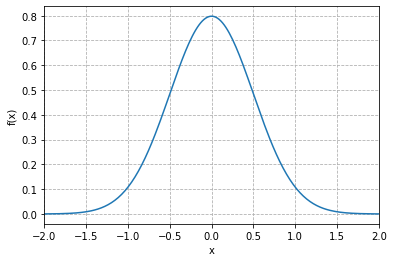

In [7]:
fig = plt.figure()
plot_normal_distro(mu=0, sigma=0.5)

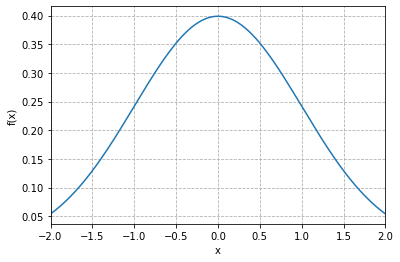

In [9]:
fig = plt.figure()
plot_normal_distro(mu=0, sigma=1)

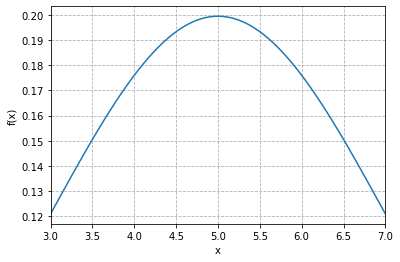

In [11]:
fig = plt.figure()
plot_normal_distro(mu=5, sigma=2)

The Gaussian distribution with mean $\mu$ and standard deviation $\sigma$ is denoted $\mathcal{N}(\mu, \sigma^2)$. To express that random variable $X$ follows the distribution, one can write $X \sim \mathcal{N}(\mu, \sigma^2)$.

### The Multivariate Gaussian Distribution

The Gaussian distribution can also be multivariate: defined over a vector of random variables $X = (X_1, \dots, X_n)^\top$ rather than a single scalar variable. To define the PDF of a multivariate Gaussian distribution, we can write [[gaussians]](#gaussians):
$$
f(\mathbf{x} | \boldsymbol\mu, \Sigma) = \frac{1}{(2\pi)^{n/2} |\Sigma|^{1/2}}
\exp\left(
-\frac{1}{2}
(\mathbf{x} - \boldsymbol\mu)^\top
\Sigma^{-1}
(\mathbf{x} - \boldsymbol\mu)
\right),
$$
where $\mathbf{x} = \left( x_1, x_2, \dots, x_n \right)^\top$ is an $n$-dimensional vector; $\mathbf{\mu} \in \mathbb{R}^n$ is the mean (now a vector) and $\Sigma$ is a symmetric positive semi-definite matrix called the covariance matrix (analogous to $\sigma$ from the univariate Gaussian distribution).

Note that $|\Sigma|$ denotes the determinant of $\Sigma$ and that $\Sigma$ needs to be a symmetric positive semi-definite $n \times n$ matrix. For a positive semi-definite $n \times n$ matrix $\Sigma$, given any column vector $\mathbf{x} \in \mathbb{R}^n$, the following will hold: $\mathbf{x}^\top \Sigma\, \mathbf{x}$ is positive or zero.

The multivariate Gaussian distribution with mean $\boldsymbol\mu$ and covariance matrix $\Sigma$ is denoted $\mathcal{N}(\boldsymbol\mu, \Sigma)$.

#### The Covariance Matrix

The covariance matrix, as its name suggests, contains covariances between the various random variables that make up the Gaussian – more specifically:
$$
\Sigma = \begin{pmatrix}
    Cov(X_1, X_1) & Cov(X_1, X_2) & \dots & Cov(X_1, X_n) \
    Cov(X_2, X_1) & Cov(X_2, X_2) & \dots & Cov(X_2, X_n) \
    \vdots & \vdots & \ddots & \vdots \
    Cov(X_n, X_1) & Cov(X_n, X_2) & \dots & Cov(X_n, X_n)
\end{pmatrix}
$$

Recall that covariance $Cov(X, Y)$ is defined as [[gaussians]](#gaussians):

$$
Cov(X, Y) = \mathbb{E}\left[
    \left( X - \mathbb{E}[X] \right)
    \left( Y - \mathbb{E}[Y] \right)
\right]
$$
and, loosely speaking, expresses the degree to which the values of the two variables tend to correspond on average.

#### The Intuitive Meaning of the Mean and of the Covariance Matrix

The function of the mean $\boldsymbol\mu$ is completely analogous to that in the univariate Gaussian distribution. It will once again determine the position of the distribution's mean: but this time in an $n$-dimensional space.

But what does the covariance matrix $\Sigma$ actually express? Let's try to build some intuition by plotting a few different distributions.

We will fix the mean to an all-zeros vector. As far as $\Sigma$ is concerned, we will first try making it a unit matrix:



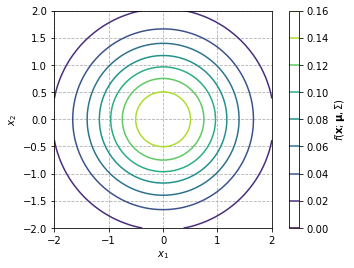

In [13]:
mu = np.array([0, 0])

sigma = np.array([
    [1, 0],
    [0, 1]
])

fig = plt.figure()
plot_normal_distro_2d(mu, sigma)

The distribution we got in this 2-dimensional case, is simply a 2-dimensional version of the bell. What changes if we modify one of the numbers at the diagonal?



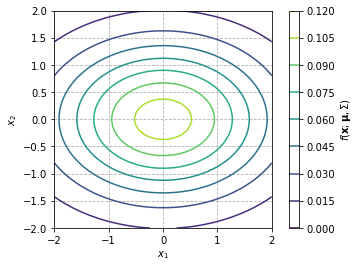

In [15]:
mu = np.array([0, 0])

sigma = np.array([
    [2, 0],
    [0, 1]
])

fig = plt.figure()
plot_normal_distro_2d(mu, sigma)

As we can see, when we make $Cov(X_1, X_1) = 2$ instead of $1$, the Gaussian becomes a bit more elongated in the direction of $X_1$. This is because the standard deviation in that direction is now greater than in the other direction, so to speak. If we also changed the $Cov(X_2, X_2)$ to 2, the contours would once again be regular circles, but the distribution as a whole would be wider than before (note how the contours are not as dense and how the ticks on the colorbar are different).



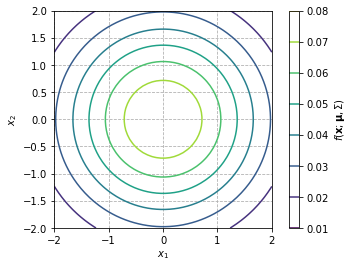

In [17]:
mu = np.array([0, 0])

sigma = np.array([
    [2, 0],
    [0, 2]
])

fig = plt.figure()
plot_normal_distro_2d(mu, sigma)

The off-diagonal terms determine the covariances between the various pairs of variables. Remember that $\Sigma$ needs to be symmetric, i.e. that $Cov(X_i, X_j) = Cov(X_j, X_i)$. Let's make $Cov(X_1, X_2)$ and $Cov(X_2, X_1)$ larger than 0 and see what happens.



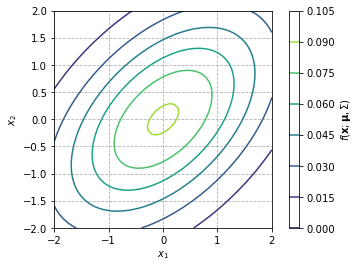

In [19]:
mu = np.array([0, 0])

sigma = np.array([
    [2, 1],
    [1, 2]
])

fig = plt.figure()
plot_normal_distro_2d(mu, sigma)

When the covariance of $X_1$ and $X_2$ was zero, they were mutually independent – each of them was free to take any value it liked, irrespective of the value of the other variable. Once we have a non-zero covariance, there is a mutual dependence between the variables. If $Cov(X_1, X_2)$ is large and positive, it's much more likely that $X_1$ and $X_2$ will have similar values and much less likely that their values will differ wildly. This is why the probability of getting e.g. $(0.5, 0.5)$ is now much greater than that of getting, say, $(0.5, -0.5)$. With zero covariance, the probabilities would have been the same.

With negative covariance, we will get the inverse relationship: whenever the value of the one variable increases w.r.t. the mean, the value of the other will tend to decrease and vice versa.



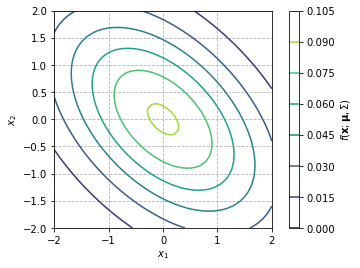

In [21]:
mu = np.array([0, 0])

sigma = np.array([
    [2, -1],
    [-1, 2]
])

fig = plt.figure()
plot_normal_distro_2d(mu, sigma)

So the takeaway intuition is that the higher the (absolute value of) covariance between two variables, the more closely related they are. We will be using this notion later when setting up our Gaussian processes.

### Probabilistic Regression: The Intuition

Let us now suppose that we are faced with a regression problem, where we have a train set: the observed input-output pairs $(x_i, y_i)$ of a function at a few points

$$
(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)
$$
and our task now is to predict the outputs for a test set of inputs: for now, let us suppose that we are only going to predict the ouput $y_{n+1}$ for a single new input $x_{n+1}$.

Let us also suppose that $x_{n+1} = 3.5$ and the data is as shown in the figure below:



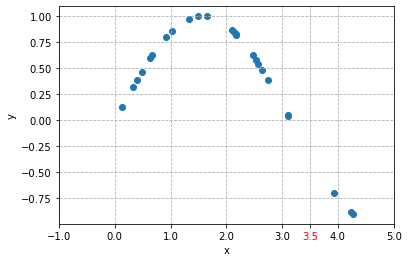

In [60]:
np.random.seed(2)
X = np.random.uniform(0, 5, 25)
Y = np.sin(X)

fig = plt.figure()
plt.scatter(X, Y)
plt.grid(ls="--")
plt.xlabel("x")
plt.ylabel("y")

highlight_tick(3.5, plt.gca())

What do we expect the output $y_{n+1}$ to be? With a standard regressor of the kind we have discussed before, we would want to settle on one single value: the one that appears to be most likely. However, speaking probabilitistically, we can choose to model the entire posterior distribution over $y_{n+1}$.

If we, as humans, were to guess at the value of $y_{n+1}$, we would probably admit that it could technically be any real number, but that some numbers would be vastly more probable than others. If we expect the function to be reasonably smooth and without singularities (which, given no evidence to the contrary, is a reasonable assumption), it is most likely that the output at $3.5$ will have a relatively strong relation to the outputs at $3$ and $4$ and possibly to some of the other outputs as well.

We would also expect that the relationship between $y_{n+1}$ and some other $y_i$ would typically be the stronger the closer $x_{n+1}$ and $x_i$ are to each other.

### Modeling Our Data Using a Gaussian

So how do we formalize our intuition? Well, we already know a distribution, where we have a way of expressing how strongly two variables are related to each other – this is precisely what we are able to express using the covariance matrix of a multivariate Gaussian distribution. So what if we constructed such a Gaussian distribution for our example? We could then get the posterior we are interested in by conditioning on our train set! This is precisely what Gaussian process regression is all about.

Let us denote our train set $D = (X, \mathbf{y})$, where $X$ is the matrix of input vectors and $\mathbf{y}$ is the vector of corresponding outputs and our test set $D_* = (X_*, \mathbf{y}_*)$. We can then construct the following Gaussian [[gpml]](#gpml):

$$
\begin{bmatrix}
\mathbf{y} \\
\mathbf{y}_*
\end{bmatrix}
\sim
\mathcal{N}\left(
    \mathcal{0},
    \begin{bmatrix}
    K & K_{*} \\
    K^\top_{*} & K_{**}
    \end{bmatrix}
\right),
$$
where the mean, for notational simplicity, is set to zero (after all, this is only the prior and in any case, we can always add the mean back in at the end) and the covariance matrix is made up by several submatrices. Namely: $K$ is the covariance matrix of the train set w.r.t. the train set, $K_{*}$ the covariance matrix of the train set w.r.t. the test set and $K_{**}$ the covariance matrix of the test set w.r.t. the test set.

#### Setting the Covariance Matrix up Using Kernel Functions

All that we need to do now is to set up the covariance matrix in a principled way. We already have the intuition that we want to have a strong relationship between points where input $x_i$ is close to input $x_j$ and a much weaker relationship or no relationship for points where the inputs are far apart. We can compute the terms in the covariance matrix using kernel functions – radial basis functions (RBFs) are a popular choice and are defined as follows [[CLNS]](#CLNS):

$$
k_{RBF}(\mathbf{x}, \mathbf{x}') = \tau \exp\left(
    \frac{-|| \mathbf{x} - \mathbf{x}' ||^2}{\sigma^2}
\right)
$$
To see why that is a reasonable choice, let us plot the function:



Text(0, 0.5, 'y')

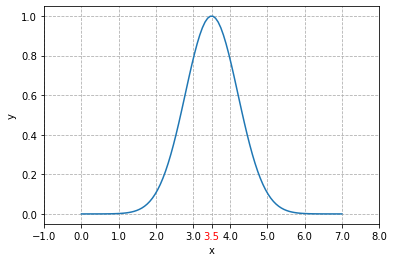

In [63]:
def RBF_func(x1, x2, sigma=1, tau=1):
    return tau * np.exp(-np.linalg.norm(x1 - x2) ** 2 / sigma **2 )

x = np.linspace(0, 7, 100)
y = [RBF_func(3.5, xx) for xx in x]

fig = plt.figure()
plt.plot(x, y)
plt.grid(ls='--')

highlight_tick(3.5, plt.gca())
plt.xlabel("x")
plt.ylabel("y")

As we can see, the function assumes value $\tau$ at its centre and values close to zero far away from it – so points close to $\mathbf{x}$ will have large covariances, while points far away from it will have near-zero covariances.

Naturally, the are many different valid choices of kernel functions and the choice may also depend on the character of the data – actually, it is one of the ways to incorporate valuable prior knowledge about the problem. E.g. when working with a periodic signal, using a periodic kernel might be a good idea.

#### Conditioning on the Train Set

Setting up the Gaussian the way we just did gives us a joint distribution for the train and the test set. In the Bayesian sense this is what we could call our *prior*  distribution. However, in our case, we already know the outputs for the train set so we can treat them as evidence and condition on them. This will give us our *posterior*  distribution: a conditional distribution $p(\mathbf{y}_{*} | X_*, X, \mathbf{y})$ over the test set.

One of the beautiful properties of the Gaussian distribution is that the conditional distribution will again be Gaussian. It will have the following form [[gpml](#gpml),[CLNS](#CLNS)]:

$$
\mathbf{y}_{*} | X_*, X, \mathbf{y} \sim
\mathcal{N}(\;
\underbrace{K_{*}^\top K^{-1} \mathbf{y}}_{\boldsymbol\mu},\;
\underbrace{K_{**} - K_{*}^\top K^{-1} K_{*}}_{\Sigma}
\;),
$$
where $X$ denotes the train set inputs and $X_*$ denotes the test set inputs.

### Gaussian Processes

Now that we have gone over all the intuition, let us define the Gaussian process (GP) itself: it is a collection of random variables (potentially infinite) such that the joint distribution of every finite subset of them is multivariate Gaussian [[CLNS]](#CLNS):

$$
f \sim \mathcal{GP}(\mu, k),
$$
where $\mu(\mathbf{x})$ is the mean function and $k(\mathbf{x}, \mathbf{x}')$ is the covariance function.

So all that we have stated above holds and we can supply our kernel function of choice for $k(\mathbf{x}, \mathbf{x}')$. We can also specify the mean function – before we have set the mean to 0 for the sake of notational simplicity, but it need not be zero. For more details on this, see [[gpml]](#gpml).

#### Gaussian Process Regression: An Example

After all the intuition and math, let us finally have our first example. We will set up an RBF kernel and use it to instantiate a Gaussian process regressor. The `RBF` kernel's parameters include `length_scale` (the $\sigma$ of the RBF) and `length_scale_bounds` (allows the $\sigma$ to be tuned within this range for the model to better fit the data).



In [ ]:
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1.0))
gp = GaussianProcessRegressor(kernel=kernel)

##### Plotting the Prior

Let's now plot our prior (the distribution not yet conditioned on any train set). The thick black line represents the mean. The shaded area represents the distance of $\pm3\sigma$ from the mean. Our model is Gaussian so we can, of course, get values outside that range too. However, more than 99.7% of values sampled under a Gaussian distribution will lie withing the $\pm3\sigma$ interval.



In [ ]:
fig = plt.figure()
x = np.linspace(0, 5, 100)
plot_distro_func_data(x, gp)

Now that we have our prior, we can sample a few functions from it. All of the curves will represent samples from the same multivariate Gaussian although their respective probabilities will, of course, not be the same. Note that the functions are all smooth – this is because drastically fast changes are very improbable under the prior.



In [ ]:
fig = plt.figure()
x = np.linspace(0, 5, 100)
plot_distro_func_data(x, gp)
y = gp.sample_y(x.reshape(-1, 1), n_samples=5)

for i in range(y.shape[1]):
    plt.plot(x, y[:, i])

##### Conditioning on Data and Plotting the Posterior

Now let us condition the GP on some data. Let's say that we observed a point $(2, 0.5)$. We will use method `gp.fit` to condition our GP on that observation.



In [ ]:
X = [2]
Y = [0.5]

gp.fit(
    np.reshape(X, (-1, 1)),
    np.reshape(Y, (-1, 1)),
)

As we can see, the GPR has the standard interface common to all scikit-learn regressors. We will therefore be able to simply call `predict` to get its predictions for new points. We have said, however, that with Gaussian processes we model the full posterior distribution: we are not just predicting its mode (the most likely outcome). So what is the interface to get that posterior from our model?

As it turns out, all we need to do is call `predict` with an additional argument `return_std=True`. We will then get our standard predictions (which represent the means of our posteriors), but also an array of standard deviations. Given that our posteriors are Gaussian, having their mean and standard deviation will, of course, fully determine their shapes.



In [ ]:
y, std = gp.predict(x.reshape(-1, 1), return_std=True)
y.shape, std.shape

We will keep using that interface when plotting the posterior. For easier comparison, we will also keep visualizing the data points on which the distribution has been conditioned (here shown in red). 

What we will see in our next plot is that our the model is now confident about the output at $2$ – having received evidence about it. Points close to $2$ have large covariances with $2$: this means that their outputs are very likely to be similar as well. As we move further away from $2$, influence of the evidence we have weakens and the distribution gets closer and closer to the prior.



In [ ]:
fig = plt.figure()
plot_distro_func_data(x, gp, X=X, Y=Y)

If we again choose to sample a few functions from our GP, we will see that, appropriately, they are now mostly contained in the new shaded area.



In [ ]:
fig = plt.figure()
x = np.linspace(0, 5, 100)
plot_distro_func_data(x, gp, X=X, Y=Y)
y = gp.sample_y(x.reshape(-1, 1), n_samples=5)

for i in range(y.shape[1]):
    plt.plot(x, y[:, i])

Let us add a few more observations just to see how new evidence might affect our estimates:



In [ ]:
X = [2, 4, 0.5]
Y = [0.5, 3.5, -2]

gp.fit(
    np.reshape(X, (-1, 1)),
    np.reshape(Y, (-1, 1)),
)

fig = plt.figure()
x = np.linspace(0, 5, 100)
plot_distro_func_data(x, gp, X=X, Y=Y)

We can see that the shape of the mean curve as well as the $\pm3\sigma$ area are now substantially different. The GP is still confident about the observed points and less confident about points in between.

### Why Use the Gaussian Distribution

While the Gaussian distribution may not be the perfect choice for all problems, it does possess several properties that make it very special and uniquely convenient for a method such as Gaussian process regression. Let us list a few of them.

#### The Central Limit Theorem

Firstly, there is the *central limit theorem*  (CLT), which states that when drawing samples $X = (x_1, x_2, \dots, x_n)$ of size $n$ from any (Gaussian or non-Gaussian, finite or infinite) population with finite mean and variance, the following function of the sample mean $\bar X$ will follow approximately the standard ($\mu=0$, $\sigma=1$) Gaussian distribution:

$$
Z = \frac{\bar X - \mu}{\sigma \sqrt{n}},
$$
where $\mu$ and $\sigma$ are the mean and the standard deviation of the original population. $Z$ will approach the standard Gaussian distribution exactly as $n \rightarrow \infty$ [[montgomery]](#montgomery).

There is, of course, a formal proof, but to get an intuitive understanding of what this means, it will be enough to replicate an example from [[montgomery]](#montgomery), which involves tossing $n$ dice. When we toss a dice, there can be six different outcomes, which are all equally probable if the dice is fair. The distribution will therefore be discrete and uniform: i.e. definitely nothing like a Gaussian:



In [ ]:
fig = plt.figure()
plt.bar(range(1, 7), [1/6 for i in range(6)])
plt.ylim([0, 1])
plt.xlabel("outcome")
plt.ylabel("probability")

plt.grid(ls="--")
plt.gca().set_axisbelow(True)

To draw a sample of size $n$ of numbers $\{ 1, 2, \dots, 6\}$, we will use the `random.randint` function from `numpy`. E.g. to draw three different samples of size 10, we will call:



In [ ]:
np.random.randint(1, 7, (3, 10))

Let us now draw samples of different sizes $n$ multiple times and observe what the distributions of the sample means look like:



In [ ]:
def plot_mean_distro(n):
    num_samples = 20000
    S = np.random.randint(1, 7, (num_samples, n))
    S_means = np.mean(S, axis=1)
    fig = plt.figure()
    bins = plt.hist(S_means, bins=250, density=True)
    plt.title("$n$={}".format(n))
    return n, fig

figs = []
figs.append(plot_mean_distro(1))
figs.append(plot_mean_distro(2))
figs.append(plot_mean_distro(3))
figs.append(plot_mean_distro(5))
figs.append(plot_mean_distro(10))

It should be obvious that as we increase $n$, the distribution is looking more and more bell-shaped – in fact it is already approaching the Gaussian distribution. Once we rescale it by subtracting the mean and dividing by the standard error (the analogy of the standard deviation, but for the sampling distribution), i.e.

$$
Z = \frac{\bar X - \mu}{\sigma / \sqrt{n}},
$$
it is going to approach the standard Gaussian distribution; note how the support changes – the distribution is now centred at 0; the range of the values is wider and also spans negative numbers.



In [ ]:
mu_die = np.sum(np.arange(1, 7) * 1/6)
sigma_die = np.sqrt(np.sum(((mu_die - np.arange(1, 7))**2)*1/6))

def plot_mean_distro(n):
    num_samples = 100000
    S = np.random.randint(1, 7, (num_samples, n))
    S_means = np.mean(S, axis=1)
    
    S_means = (S_means - mu_die) / (sigma_die / np.sqrt(n))
    
    fig = plt.figure()
    bins = plt.hist(S_means, bins=250, density=True)
    plt.title("$n$={}".format(n))
    return n, fig

figs = []
figs.append(plot_mean_distro(1))
figs.append(plot_mean_distro(2))
figs.append(plot_mean_distro(3))
figs.append(plot_mean_distro(5))
figs.append(plot_mean_distro(10))

#### Once Gaussian, Always Gaussian

As [[CLNS]](#CLNS) notes, another special feature of Gaussians is that there is a number of operations that you can do with them that will still yield a Gaussian. Among probability distributions, this makes Gaussians quite unique.

Let us have a Gaussian random variable $y = \begin{bmatrix} \mathbf{y}_A \\ \mathbf{y}_B \end{bmatrix}$ with mean $\begin{bmatrix} \boldsymbol\mu_A \\ \boldsymbol\mu_B \end{bmatrix}$ and covariance matrix
$\begin{bmatrix}
\Sigma*{AA} & \Sigma* {AB} \
\Sigma*{BA} & \Sigma* {BB}
\end{bmatrix}$; the following operations will be among those that will yield a Gaussian [[CLNS]](#CLNS):

* **Marginalization:**  The marginal distributions $p(\mathbf{y}_A)=\int_{\mathbf{y}_B} p(\mathbf{y}_A, \mathbf{y}_B; \boldsymbol\mu, \Sigma) d\mathbf{y}_B$ and $p(\mathbf{y}_B) = \int_{\mathbf{y}_A} p(\mathbf{y}_A, \mathbf{y}_B; \boldsymbol\mu, \Sigma) d\mathbf{y}_A$ will be Gaussian, i.e.:
$$
\begin{aligned}
\mathbf{y}_A &\sim \mathcal{N}\left( \boldsymbol\mu_A, \Sigma_{AA} \right) \\
\mathbf{y}_B &\sim \mathcal{N}\left( \boldsymbol\mu_B, \Sigma_{BB} \right)
\end{aligned}
$$
* **Conditioning:**  The conditional distribution of $y_A$ on $y_B$
$$
p(\mathbf{y}_A | \mathbf{y}_B) = \frac{
    p(\mathbf{y}_A, \mathbf{y}_B; \boldsymbol\mu, \Sigma)
}{
    \int_{\mathbf{y}_A} p(\mathbf{y}_A, \mathbf{y}_B; \boldsymbol\mu, \Sigma) d\mathbf{y}_A
}
$$will also be Gaussian:

$$
\begin{aligned}
\mathbf{y}_A | \mathbf{y}_B \sim \mathcal{N}(
    &\boldsymbol\mu_A + \Sigma_{AB} \Sigma^{-1}_{BB} (\mathbf{y}_B - \boldsymbol\mu_B), \\
    &\Sigma_{AA} - \Sigma_{AB} \Sigma^{-1}_{BB} \Sigma_{BA}
).
\end{aligned}
$$
* **Summation:**  Summing up two Gaussian distributions yields a Gaussian distribution, i.e.:
$$
\begin{aligned}
\mathbf{y} &\sim \mathcal{N}(\boldsymbol\mu, \Sigma) \\
\mathbf{y}' &\sim \mathcal{N}(\boldsymbol\mu', \Sigma')
\end{aligned}
$$means that:

$$
\mathbf{y} + \mathbf{y}' \sim \mathcal{N}(\boldsymbol\mu + \boldsymbol\mu', \Sigma + \Sigma').
$$
These properties are very useful in the context of Gaussian processes – if e.g. we got a non-Gaussian distribution when conditioning on data, or if the relationship between the original and the conditioned distribution were much more complex, this would make things quite a bit more difficult.

### Using a Periodic Kernel

Kernels are a very versatile tool and they can help us incorporate a lot of prior knowledge. In fact, in many cases, if we were able to design the perfect kernel, the task would essentially be solved. As an example of this, let us suppose that the function we are modeling is periodic. We can use a special `ExpSineSquared` kernel based on the sine function. The kernel is defined as follows [[exp_sine_squared]](#exp_sine_squared):

$$
k(\mathbf{x}_i, \mathbf{x}_j) = \exp\left[
-\frac{
    2\sin^2\left( \frac{\pi ||\mathbf{x}_i - \mathbf{x}_j||_2 }{p} \right)
}{
    l^2
}        
\right],
$$
where $p$ is the periodicity of the kernel, $l$ is the length scale of the kernel (determines how fast the kernel value decays with increasing distance within the closest half-period) and $||\cdot||_2$ is the Euclidean norm.

An illustration of the kernel is given below for periodicity of $p=3$ and for different values of length scale.



In [ ]:
def exp_sine_squared(dist, preriod, length_scale):
    return np.exp(-(2*np.sin(np.pi * dist / preriod)**2) / (length_scale**2))

dist = np.linspace(0, 10, 100)
period = 3

k05 = exp_sine_squared(dist, period, length_scale=0.5)
plt.plot(dist, k05, label="$l=0.5$")

k1 = exp_sine_squared(dist, period, length_scale=2)
plt.plot(dist, k1, label="$l=2$")

plt.legend()
plt.grid(ls='--')
plt.xlabel('distance')
plt.ylabel('kernel value')

Let us now suppose that we are modeling the sine function with frequency $1.27$, i.e. $f(x) = \sin(1.27 \cdot 2\pi x)$. The periodicity of this function will, of course, be $p = \frac{1}{1.27}$.



In [ ]:
freq = 1.27
func = lambda x: np.sin(2*np.pi*freq*x)
periodicity = 1 / freq

To account for the periodicity, we will use the `ExpSineSquared` kernel and specify the periodicity of our function.



In [ ]:
kernel = 1.0 * ExpSineSquared(periodicity=periodicity,
    length_scale=1.0, length_scale_bounds=(1e-1, 1.0))
gp = GaussianProcessRegressor(kernel=kernel)

If we then condition on a few representative data points in the function's first period, we will automatically get the same predictions for any subsequent periods. Note also how the uncertainties from the first period are carried over to the subsequent ones.



In [ ]:
X = np.linspace(0, 2, 5)
Y = func(X)

gp.fit(
    np.reshape(X, (-1, 1)),
    np.reshape(Y, (-1, 1)),
)

fig = plt.figure()
x = np.linspace(0, 5, 100)
plot_distro_func_data(x, gp, X=X, Y=Y, func=func)

Naturally, the function we are modelling need not be a sine function – the kernel will work with other periodic functions as well: but we do need to know what the periodicity is. Here is an example for a function that mixes several different sine and cosine components:



In [ ]:
func = lambda x: np.cos(2*np.pi*x/2) + np.cos(2*np.pi*x/3) + np.sin(np.pi*x)
periodicity = 6

kernel = ExpSineSquared(periodicity=periodicity)
gp = GaussianProcessRegressor(kernel=kernel)

x = np.linspace(0, 15, 100)
X = np.linspace(0.5, 5.5, 7)
Y = func(X)

gp.fit(
    np.reshape(X, (-1, 1)),
    np.reshape(Y, (-1, 1)),
)

fig = plt.figure()
plot_distro_func_data(x, gp, X=X, Y=Y, func=func)

### Allowing for Noise in the Observations

So far we have supposed that we can observe the true target $\mathbf{y}$ directly and precisely. However, this is almost never true in practice – the targets are almost always noisy (whether it is due to measurement error or some other extraneous factors). We can model this noise as an additive zero-mean Gaussian component. The observed target will then be:

$$
y_{obs} = y + \epsilon,
$$
where $\epsilon \sim \mathcal{N}(0, \sigma^2)$ is the i.i.d. (independent and identically distributed – across observations and dimensions here) Gaussian with mean $0$ and variance $\sigma^2$.

If we want to incorporate this into our model, we need to include this noisy component in our covariance matrix. Since the noise affects each of the variables independently, we only need to add its variance to the diagonal [[CLNS]](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote15.html):

$$
\Sigma' = \Sigma + \sigma^2\mathbf{I},
$$where $\mathbf{I}$ is a unit matrix with the same dimensions as $\Sigma$.

When we take into account that we compute the covariance matrix using our kernel function, we can equivalently modify that function by adding the new component to all on-diagonal terms. In `scikit-learn` this is done using `WhiteKernel`:



In [ ]:
kernel = (1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1.0))
           + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-15, 1e5)))
gp = GaussianProcessRegressor(kernel=kernel)

Note first how adding the additional noise component makes our prior a bit wider:



In [ ]:
fig = plt.figure()
x = np.linspace(0, 5, 100)
plot_distro_func_data(x, gp)

#### The Same Point Being Observed Multiple Times

More importantly, when conditioning on observed points, the GP is now not 100% confident even about the observed values.



In [ ]:
X = [2]
Y = [0.5]

gp.fit(
    np.reshape(X, (-1, 1)),
    np.reshape(Y, (-1, 1)),
)

fig = plt.figure()
plot_distro_func_data(x, gp, X=X, Y=Y)

It will, of course, become progressively more confident, if they are observed several times.



In [ ]:
X = [2, 2]
Y = [0.5, 0.5]

gp.fit(
    np.reshape(X, (-1, 1)),
    np.reshape(Y, (-1, 1)),
)

fig = plt.figure()
plot_distro_func_data(x, gp, X=X, Y=Y)

### The Weight-Space View

What we were discussing so far was the function-space view of Gaussian processes – where the Gaussian distribution conditioned on data would essentially allow us to sample functions. There is, however, another view: the weight-space view, which eventually reaches the same results, but from an altogether different starting point. Since this other view will help to provide a fuller understanding of what Gaussian processes do, we will go over it – even though just very briefly.

To this purpose we will first consider the standard linear regression model expressed as [[gpml]](#gpml)

$$
f(\mathbf{x}) = \mathbf{x}^\top \mathbf{w}.
$$
The target output $y$ includes some noise $\varepsilon$, which we will expect to be Gaussian distributed, i.e. [[gpml]](#gpml)

$$
\begin{aligned}
y &= f(\mathbf{x}) + \varepsilon \\
\varepsilon &\sim \mathcal{N}(0, \sigma_n^2).
\end{aligned}
$$
#### Maximum Likelihood Estimation (MLE)

When performing standard linear regression, we would have used the ordinary least squares method to do **maximum likelihood estimation**  (MLE) and thus arrive at the most likely weight vector $\mathbf{w}$. Given a dataset composed of inputs $X$ and desired outputs $\mathbf{y}$, the most likely weight vector would be the one maximizing the likelihood function, i.e. [[gpml]](#gpml)

$$
p(\mathbf{y} | X, \mathbf{w}).
$$
#### Maximum a Posteriori (MAP) Estimation

In addition to MLE, there is another option, which we have also discussed: we could choose to include a regularization term. For instance, we could discourage overly large weight vectors by including a penalty term of the form $\mathbf{w}^\top \mathbf{w}$ in the objective function. This would yield the method known as *ridge regression* .

By including such term, we are essentially putting a non-uniform prior distribution over the weight vector $\mathbf{w}$. We are stating that smaller weight vectors are more likely than large ones. If, for instance, we suppose that the weight vector $\mathbf{w}$ is from a zero-mean Gaussian prior with covariance matrix $\Sigma_p$ [[gpml]](#gpml)

$$
\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \Sigma_p)
$$
we can express the probability distribution over $\mathbf{w}$ using the Bayes rule [[gpml]](#gpml):

$$
p(\mathbf{w} | \mathbf{y}, X) = \frac{
    p(\mathbf{y} | X, \mathbf{w}) p(\mathbf{w})
}{
    p(\mathbf{y} | X)
}.
$$
If we find the vector $\mathbf{w}$, which maximizes this posterior, we have performed what is known as **maximum a posteriori (MAP) estimation** , i.e. we have also taken a prior over $\mathbf{w}$ into account. Actually, the usual approach is to ignore the normalizing term in the denominator (which does not depend on $\mathbf{w}$) and maximize the $\log$ of this probability. And this, incidentally, yields *the objective function of ridge regression*  exactly [[gpml](#gpml),[bayeslin](#bayeslin)].

#### The Full Bayesian Approach

What MLE and MAP have in common is that they both settle on a single weight vector $\mathbf{w}$ – they only choose different objective function for $\mathbf{w}$ to maximize. In contrast to that, the full Bayesian approach sets out to find the entire posterior over $\mathbf{w}$ – i.e. all the possible weight vectors $\mathbf{w}$ and their respective probabilities. In the Gaussian case, it is possible to express the posterior analytically and, indeed, it is again Gaussian (once Gaussian, always Gaussian, right?).

That is all very well, of course, but how do we make predictions if we no longer have a single $\mathbf{w}$, but rather the full distribution over it? Well, what we can do when computing our predictions, is to **average over all possible weight vectors $\mathbf{w}$, weighting by their posterior probabilities**  [[gpml]](#gpml):

$$
p(y_* | \mathbf{x}_*, X, \mathbf{y}) =
    \int p(\mathbf{w} | X, \mathbf{y}) p(y_* | \mathbf{x}_*, \mathbf{w}) d\mathbf{w}.
$$
It will probably not surprise the reader at this point that this probability can again be expressed analytically and that it is again a Gaussian. In fact, once the kernel trick is introduced to map the points into a high-dimensional space, the result corresponds exactly to the math for Gaussian processes with noisy observations that we got through the functional view [[gpml]](#gpml). For a fuller treatment, including all the mathematical details, the reader can refer to [[gpml]](#gpml).

### The Full Bayesian Approach in Non-Gaussian Settings

As a final note, it is perfectly possible to use the full Bayesian approach with non-Gaussian models, but the math is no longer nearly as nice and the solutions typically have to be approximated in some way. It is even possible to train Bayesian neural networks, where instead of a single set of weights, we have a distribution over them. However, this is rather computationally expensive and the predictions need to be made by sampling a few weight matrices and averaging the predictions.



### References

<a id="montgomery">[montgomery]</a> Montgomery DC, Runger GC. Applied statistics and probability for engineers. John Wiley & Sons; 2007.

<a id="gaussians">[gaussians]</a> Chuong B. Do. The Multivariate Gaussian Distribution. [http://cs229.stanford.edu/section/gaussians.pdf](http://cs229.stanford.edu/section/gaussians.pdf).

<a id="gpml">[gpml]</a> C. E. Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning, the MIT Press, 2006,
ISBN 026218253X. [http://www.gaussianprocess.org/gpml](http://www.gaussianprocess.org/gpml).

<a id="CLNS">[CLNS]</a> Kilian Weinberger. Lecture 15: Gaussian Processes. CS4780/CS5780: Machine Learning for Intelligent Systems, 2018 Fall Lecture Notes, Cornell University. [https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote15.html](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote15.html).

<a id="bayeslin">[bayeslin]</a> Agustinus Kristiadi. Linear Regression: A Bayesian Point of View. <https://wiseodd.github.io/techblog/2017/01/05/bayesian-regression/>

<a id="exp_sine_squared">[exp_sine_squared]</a> ExpSineSquared. Scikit-Learn. <https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html>

